In [1]:
import numpy as np
from matplotlib import pyplot as plt
from SYK_fft import *
from ConformalAnalytical import *
import testingscripts

In [2]:
testingscripts.realtimeFFT_validator() # Should return True

True

In [3]:
def rhotosigma(rhoG,rhoD,M,dt,t,g,kappa=1,delta=1e-6):
    '''
    returns [Sigma,Pi] given rhos
    '''
    rhoGrev = np.concatenate(([rhoG[-1]], rhoG[1:][::-1]))
    rhoFpp = (1/np.pi)*freq2time(rhoG * fermidirac(beta*omega),M,dt)
    rhoFpm = (1/np.pi)*freq2time(rhoG * fermidirac(-1.*beta*omega),M,dt)
    rhoFmp = (1/np.pi)*freq2time(rhoGrev * fermidirac(beta*(omega)),M,dt)
    rhoFmm = (1/np.pi)*freq2time(rhoGrev * fermidirac(-1.*beta*omega),M,dt)
    rhoBpp = (1/np.pi)*freq2time(rhoD * boseeinstein(beta*(omega+delta)),M,dt)
    rhoBpm = (1/np.pi)*freq2time(rhoD * boseeinstein(-1.*beta*(omega+delta)),M,dt)
    
    argSigma = (rhoFpm*rhoBpm - rhoFpp*rhoBpp) * np.exp(-np.abs(delta*t)) * np.heaviside(t,1.0)
    Sigma = 1j*(g**2)*kappa * time2freq(argSigma,M,dt)
    
    argPi = (rhoFpp*rhoFmp - rhoFpm*rhoFmm) * np.exp(-np.abs(delta*t)) * np.heaviside(t,1.0)
    Pi = 2*1j*(g**2) * time2freq(argPi,M,dt)
    
    return [Sigma, Pi]

In [4]:
g = 0.5
mu = 0.
r = 1.
eta = 1e-6
beta = 50.

M = int(2**18) #number of points in the grid
T = 2000 #upper cut-off fot the time
dt = (2*T)/((2*M))
t = dt * (np.arange(2*M) - M)

dw = np.pi/(M*dt)
omega = dw * (np.arange(2*M) - M) 
np.testing.assert_almost_equal(dt*dw*M,np.pi,5, "Error in fundamentals")
err = 1e-4

delta = 1e-3
np.testing.assert_almost_equal(np.max(np.abs(omega)),np.pi*M/T,5,"Error in creating omega grid")




In [5]:
#GRomega = (1j)*np.ones(2*M)
#GRomega = time2freq(GRconf(t+1j*delta,J = Jot,beta = beta),M,dt)
GRomega = 1/(omega + 1j*delta + mu)
DRomega = -1/((omega+1j*delta)**2 - r)


itern = 0

diff = 1 
diffG,diffD = (0.5,0.5)
xG,xD = (0.5,0.5)

while (diff>err and itern<200): 
    itern += 1 
    diffoldG,diffoldD = (diffG,diffD)
    GRoldomega,DRoldomega = (1.0*GRomega, 1.0*DRomega)
    
    rhoG = -1.0*np.imag(GRomega)
    rhoD = -1.0*np.imag(DRomega)
    
    SigmaOmega,Piomega = rhotosigma(rhoG,rhoD,M,dt,t,g,kappa=1,delta=1e-6)
   
    GRomega = 1.0*xG/(omega + 1j*eta + mu - SigmaOmega) + (1-xG)*GRoldomega
    DRomega = 1.0*xD/(-(omega+1j*eta)**2 + r - Piomega) + (1-xD)*DRoldomega
   
    diffG = np. sqrt((0.5/M) * np.sum((np.abs(GRomega-GRoldomega))**2)) #changed
    diffD = np. sqrt((0.5/M) * np.sum((np.abs(DRomega-DRoldomega))**2))
    diff = np.max([diffG,diffD])
    
    if diffG>diffoldG:
        xG/=2.
    if diffD>diffoldD:
        xD/=2.
    print("itern = ",itern, " , diff = ", diffG, diffD, " , x = ", xG, xD, end = '\r')
        



/Users/aravindhswaminathan/Documents/GitHub/TwoSidedYSYK/SYK_fft.py:87: RuntimeWarning: overflow encountered in exp
  return (1.0/(1.0 + np.exp(arg)))
/Users/aravindhswaminathan/Documents/GitHub/TwoSidedYSYK/SYK_fft.py:102: RuntimeWarning: overflow encountered in exp
  return (1.0/(np.exp(arg)-1))


In [6]:
GRt = (0.5/np.pi) * freq2time(GRomega,M,dt)
DRt = (0.5/np.pi) * freq2time(DRomega,M,dt)

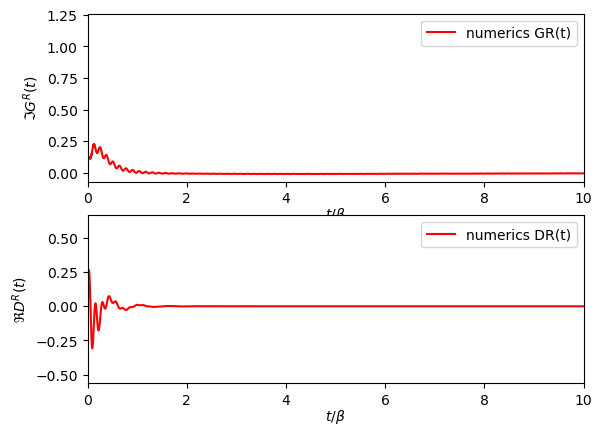

In [7]:
fig, ax = plt.subplots(2)

ax[0].plot(t/beta, np.imag(GRt), 'r', label = 'numerics GR(t)')
#ax[0].plot(tau/beta, np.real(Gconftau), 'b--', label = 'analytical Gtau' )
#ax[0].set_ylim(-1,1)
ax[0].set_xlim(0,10)
ax[0].set_xlabel(r'$t/\beta$',labelpad = 0)
ax[0].set_ylabel(r'$\Im{G^R(t)}$')
ax[0].legend()

ax[1].plot(t/beta, np.real(DRt), 'r', label = 'numerics DR(t)')
#ax[1].plot(tau/beta, np.real(Dconftau), 'b--', label = 'analytical Dtau' )
#ax[1].plot(tau/beta, np.real(FreeDtau), 'g-.', label = 'Free D Dtau' )
#ax[1].set_ylim(0,1)
ax[1].set_xlabel(r'$t/\beta$',labelpad = 0)
ax[1].set_ylabel(r'$\Re{D^R(t)}$')
ax[1].set_xlim(0,10)
ax[1].legend()


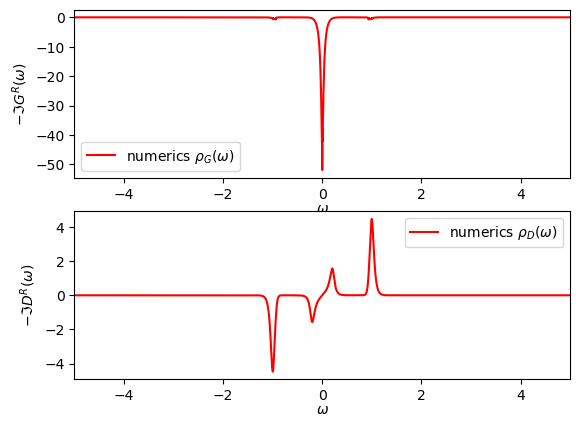

In [8]:
fig, ax = plt.subplots(2)

ax[0].plot(omega, rhoG, 'r', label = r'numerics $\rho_G(\omega)$')
#ax[0].plot(tau/beta, np.real(Gconftau), 'b--', label = 'analytical Gtau' )
#ax[0].set_ylim(-1,1)
ax[0].set_xlim(-5,5)
ax[0].set_xlabel(r'$\omega$',labelpad = 0)
ax[0].set_ylabel(r'$-\Im{G^R(\omega)}$')
ax[0].legend()

ax[1].plot(omega, rhoD, 'r', label = r'numerics $\rho_D(\omega)$')
#ax[1].plot(tau/beta, np.real(Dconftau), 'b--', label = 'analytical Dtau' )
#ax[1].plot(tau/beta, np.real(FreeDtau), 'g-.', label = 'Free D Dtau' )
#ax[1].set_ylim(0,1)
ax[1].set_xlabel(r'$\omega$',labelpad = 0)
ax[1].set_ylabel(r'$-\Im{D^R(\omega)}$')
ax[1].set_xlim(-5,5)
ax[1].legend()


In [9]:
dw, dt

(0.0015707963267948967, 0.00762939453125)

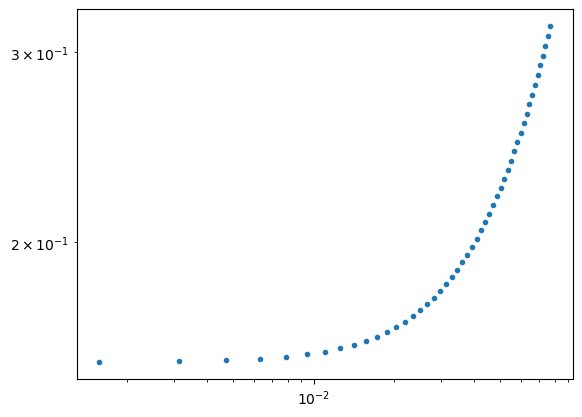

In [10]:
Delta = 0.42
plt.loglog(omega[M+1:M+50], np.abs(DRomega[M+1:M+50]),'.') 
fudfacD = DRt[M+1]/t[M+1]
#plt.loglog(t[M+1:M+50])